In [482]:
import numpy as np
import matplotlib.pyplot as plt


# Week 5
We begin by using the function from class exercises. To recap, we consider Newton's Law of Gravitation, which states that a force between two objects, exterted on the first object
$$
\begin{equation} \vec{F} = \frac{GMm}{r^2} \hat{r} \end{equation}
$$
where $G$ is the gravitational constant, $M$ and $m$ are the masses of the objects, $\vec{r_{12}} = \vec{r_2} - \vec{r_1}$, $r = |\vec{r_{12}}|$ and $\hat{r} = \frac{\vec{r_{12}}}{|\vec{r_{12}}|}$.

In [483]:
def force(r1,r2,m1,m2):
    """
    Calculates the gravitational force on a mass m1 at position r1
    from a mass m2 at position r2
    
    Inputs
    r1        Position of the first mass
    r2        Position of the second mass
    m1        First mass
    m2        Second mass

    Returns
    f_on_m1   Force on m1 as a result of m2    
    """
    # Finding r_12 and its magnitude
    r_12 = r2 - r1
    return (G * m1 * m2)/(np.sqrt(r_12[0]**2 + r_12[1]**2))**3 * r_12

Using $\mathrm{(1)}$, equating this to the equation for the formula for centripetal force
$$ \begin{equation} \vec{F} = \frac{mv^2}{r}\hat{r} \end{equation} $$
and rearranging, one obtains an expression for tangential velocity 

$$ \begin{equation} v = \sqrt{\frac{GM}{r}}. \end{equation} $$

In the example below, the initial velocity of planet 2 is determined by this (assuming that planet 1 is fixed at the centre). Then, the same is calculated for planet 3 but with the centre of the orbit fixed on planet 2, and the initial velocity of planet 2 is added to this. If this is successful, planet 2's frame of reference should show planet 3 orbiting with a circular orbit.

In [484]:
# Simulation parameters
G = 1
m1 = 1
m2 = 3e-6
m3 = 3.6e-8
Ndim = 2     
Nsteps = 20000
dt = 0.001

# Storage arrays
r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.0, 0.0025)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((-np.sqrt(G*m2/0.0025), 0)) + v2[0]


The velocity Verlet integrator is used from previous assignments. Given a position $x(t)$ and velocity $v(t)$, the propagation of these quantities by a quantity $\Delta t$ can be expressed as 
$$\begin{align}
    x(t + \Delta t) &= x(t) + v(t)\Delta t  + \frac{F(t)}{2m} \Delta t^2 \\ 
    v(t + \Delta t) &= v(t) + \frac{F(t) + F(t + \Delta t)}{2m} \Delta t
\end{align} $$
where $F(t)$ and $m$ is the force on and mass of the object being simulated.

In [485]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) + force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) + force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



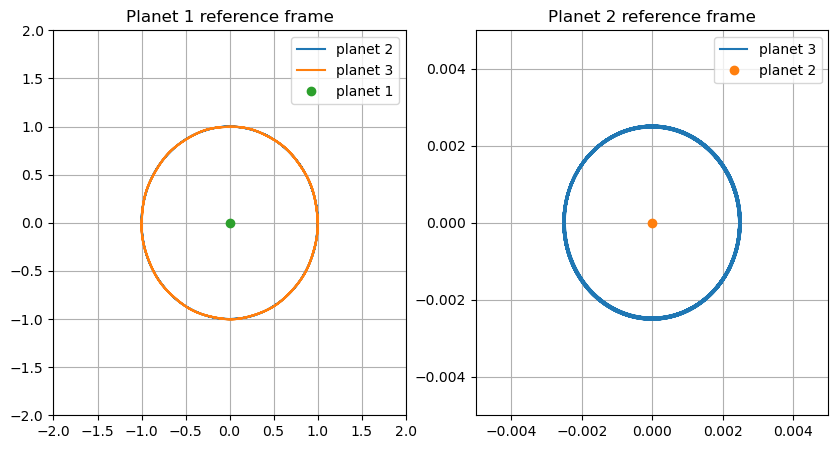

In [486]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(1,2,1)
ax1.set_title('Planet 1 reference frame')
ax1.plot(r2[:,0], r2[:,1], label='planet 2')
ax1.plot(r3[:,0], r3[:,1], label='planet 3')
ax1.plot(0, 0, 'o', label='planet 1')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.legend()
ax1.grid()

ax2 = fig1.add_subplot(1,2,2)
ax2.set_title('Planet 2 reference frame')
ax2.plot(r2[:,0]-r3[:,0], r2[:,1]-r3[:,1], label='planet 3')
ax2.plot(0, 0, 'o', label='planet 2')
ax2.set_xlim(-0.005,0.005)
ax2.set_ylim(-0.005,0.005)
ax2.legend()
ax2.grid()


As is shown by the plot above, the velocity Verlet method gave rise to a good approximation of a 3-body system, which is shown by the circular orbit in planet 2's frame of refernce. Despite this, the orbit is somewhat thick, demonstrating some error in the simulation.

# Week 6/7

Moving on, we attempt the fourth-order Runge-Kutta integrator with a two-body system. The algorithm, written out in the below function is 

$$

\begin{matrix} y(x+\mathrm{\Delta x})&=&y(x)+\frac{1}{6}\left(k_1+2k_2+2k_3+k_4\right)\\k_1&=&\mathrm{\Delta x}\ f(x,y(x))\\k_2&=&\mathrm{\Delta x}\ f(x+\mathrm{\Delta x}/2,y(x)+k_1/2)\\k_3&=&\mathrm{\Delta x}\ f(x+\mathrm{\Delta x}/2,y(x)+k_2/2)\\k_4&=&\mathrm{\Delta x}\ f(x+\mathrm{\Delta x},y(x)+k_3) \end{matrix}

$$.

In [487]:
def RK4_solver(fun,y0,dt,N):
    """Solve dy/dt = fun(y,t) using fourth-order RK method.
    Inputs:
    fun  f(y,t)
    y0   Initial condition - assumed to be two-component
    dt   Step size
    N    Number of steps
    Returns: two arrays of length N+1 (x and v or equivalent)
    """
    # Storage for solution
    y = np.zeros((N+1,2,2))
    # Initial condition
    y[0] = y0
    t = 0
    for i in range(N):
        # RK4 formulae
        k1 = dt*fun(y[i],t,N)
        k2 = dt*fun(y[i]+0.5*k1,t+0.5*dt,N)
        k3 = dt*fun(y[i]+0.5*k2,t+0.5*dt,N)
        k4 = dt*fun(y[i]+k3,t+dt,N)
        y[i+1]=y[i]+(k1+2*k2+2*k3+k4)/6
        t += dt
    return y



In order to implement the Runge-Kutta integrator, the second order differential equation concerning our system (taken from manipulating $\mathrm{(1)}$)

$$ \frac{d^2x}{dt^2} = \frac{GM}{r} $$ 
can be decoupled into two first-order equations by using the fact that $dx/dt = v$:

$$ \begin{align}
\frac{dx}{dt} &= v \\
\frac{dv}{dt} &= \frac{GM}{r}.
\end{align}
$$

This was encoded into a function `p2_RHS`, which was passed into the RK solver.

In [488]:
def p2_RHS(y,t,n):
    m1 = 1.0

    pos = y[0]
    vel = y[1]

    r12 = np.array([0,0]) - pos
    r12_mag_cubed = np.linalg.norm(r12)**3
    
    dpos = vel
    dvel = G*m1*r12/r12_mag_cubed

    return np.array([dpos,dvel])

A different approach was taken with the initial conditions, as now $2\times2$ arrays with the first row as position and the second as velocity were used, as opposed to dealing with them separately in the Verlet integrator.

In [489]:
p2_initial_pos = np.array([1,0])
p2_initial_vel = np.array([0,np.sqrt(G*m1/1)])

N = 2000
dt = 0.01
p2_y_0 = np.array([p2_initial_pos, p2_initial_vel])

p2_results = RK4_solver(p2_RHS, p2_y_0, dt, N)

print(p2_results[0])

[[1. 0.]
 [0. 1.]]


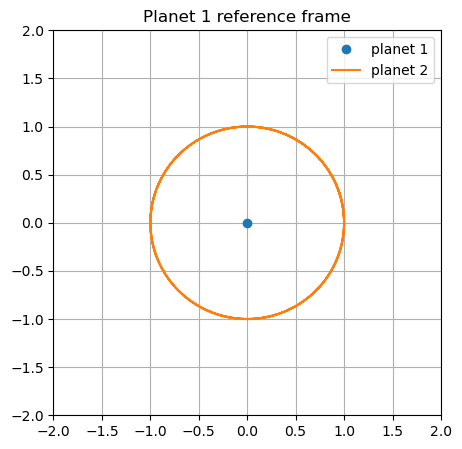

In [490]:
plt.figure(figsize=(5,5))
plt.title('Planet 1 reference frame')
plt.plot(0, 0, 'o', label='planet 1')
plt.plot(p2_results[:,0,0], p2_results[:,0,1], label='planet 2')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

The fourth-order Runge-Kutta integrator is a good tool to use for 

# Week 8
## Simulating a Gravity Assist between a planet and a smaller object

Moving on from the mandatory part of the investigation, I will attempt to simulate a gravitational slingshot between a satellite and Earth in a circular orbit. Given my success with the velocity Verlet algorithm, the simulation will use this from this point onwards.
\
\
To achieve this, we begin by initialising the orbit of Earth around the Sun like before. The satellite will be given an arbitrary position $(1.5, 1.5)$, and a trajectory to planet 2 will be calculated. Now, for the sake of simplicity, I will decide for the point of intersection to be around the point $(0,1)$ on the circular orbit of planet 2. Some kinematics will be used to determine the initial velocity planet 3. Most variables from earlier were used and adapted accordingly. 

\
\
A function `collision_checker` was also made to check for any collisions between the satellite and Earth. The tolerance was decided by calculating the radius of the Earth as a fraction of the distance from the Sun to the Earth. This was calculated to be $\approx 4\times 10^{-5}$.

In [491]:
def collision_checker(r1, r2):
    '''
    A function to check to see if two objects have collided.
    The tolerance was chosen based on earlier calculations

    Inputs:
    r1, r2   Positions of the two bodies
    '''
    if np.linalg.norm(r1 - r2) <= 4e-5:
        print('Collision!')

In order to determine the velocity required for the satellite to reach Earth at the interception point, I initially ran the simulation without the satellite to determine the timestep where Earth would reach this point. Then, using some simple kinematics, I calculated the initial velocity using the distance from the satellite's initial position (known) and the time elapsed up to the timestep. This was calculated by multiplying the array position (in this case 1570) by `dt`. I also offset the final position slightly on the x-axis to allow the satellite to pass behind Earth.

In [492]:
G = 1
m1 = 1
m2 = 3e-6
m3 = 1e-27
Ndim = 2    
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.5, 1.5)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(0.001-1.5), 
                  1/1.57*(1-1.5)))


Unlike the algorithm above, I have neglected the effect of the Sun on satellite. This was done so that I could examine the effects of Earth of the satellite without having to consider any interactions with the Sun. I will consider adding the effect of the Sun once most aspects of the simulation work well.

In [493]:
for i in range(Nsteps-1):
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



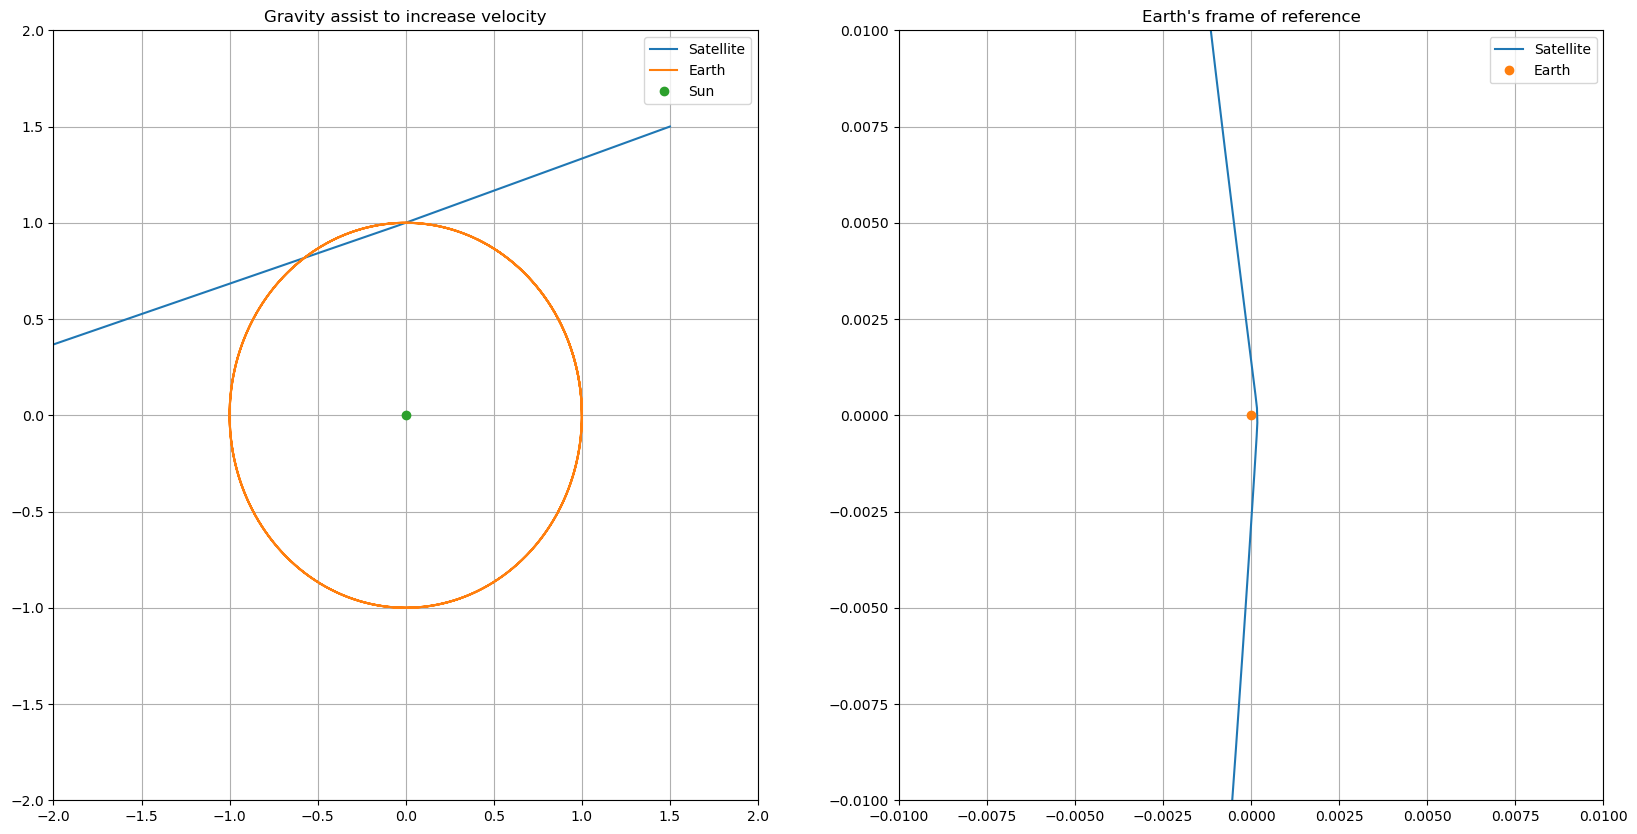

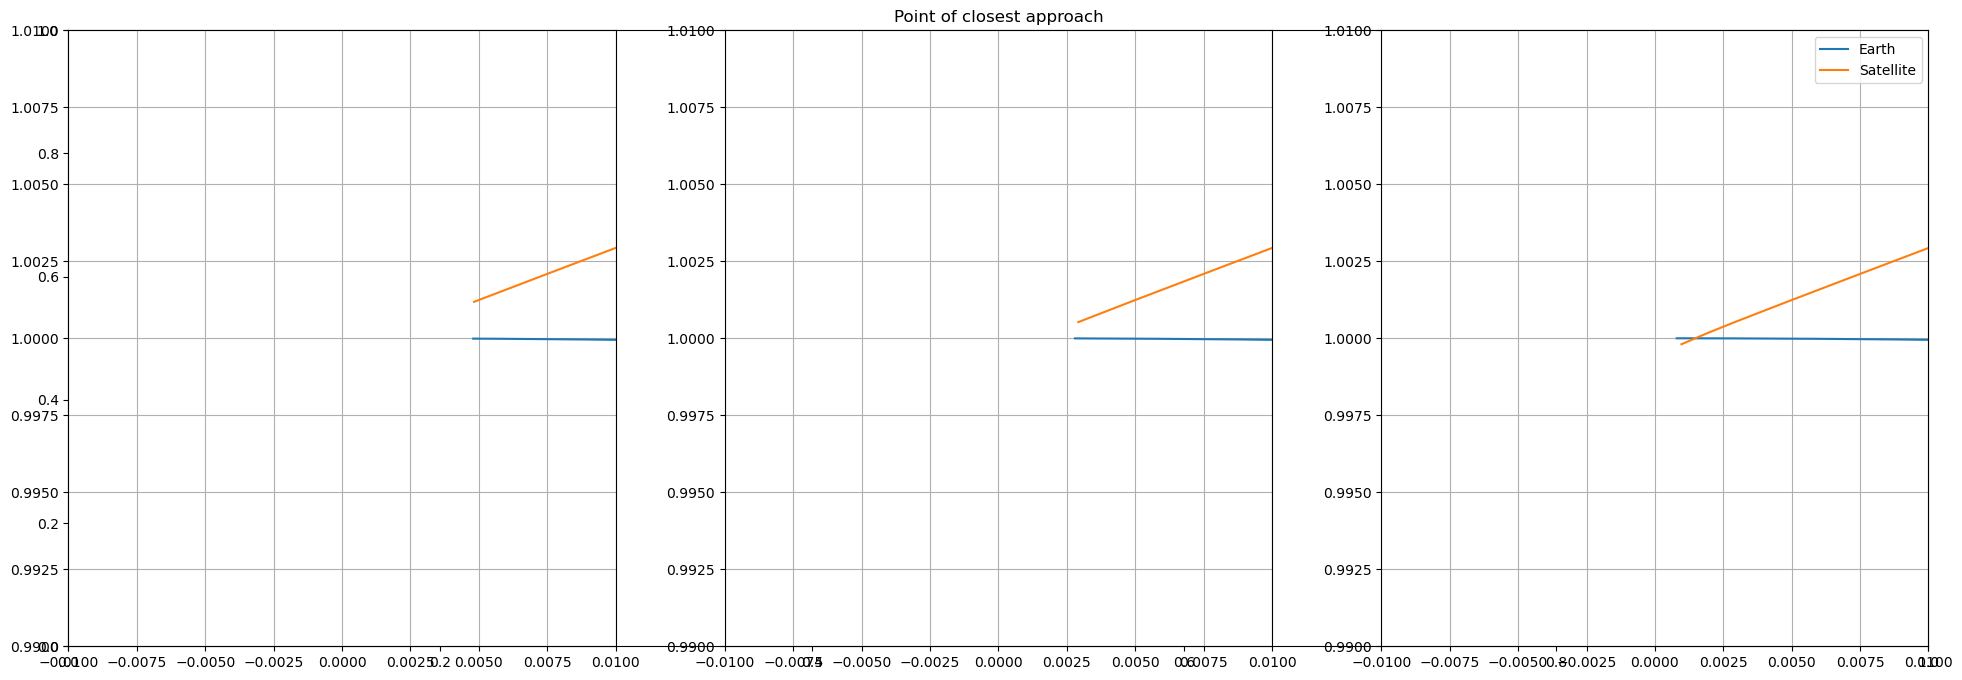

In [494]:
fig = plt.figure(figsize=(20,10 ))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Gravity assist to increase velocity')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Earth')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Earth\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.01, 0.01)
ax2.set_ylim(-0.01, 0.01)
ax2.plot(0,0,'o',label='Earth')
ax2.grid()
ax2.legend()


simend = 1565
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 2*i,0], r2[:simend + 2*i,1], label='Earth')
    ax.plot(r3[:simend + 2*i,0], r3[:simend + 2*i,1], label='Satellite')
    ax.set_xlim(-0.01, 0.01)
    ax.set_ylim(0.99, 1.01)
    ax.grid()
plt.legend()



In [495]:
'''# Rough work
print(r2[1570,1])
print(1/1.57*(r2[1570,0] - r3[0,0]))
print(1/1.57*(r2[1570,1] - r3[0,1]+0.08))

print(v3[0,1])
print(v3[-1,1])

print(np.linalg.norm(v3[0]))

print(max(np.linalg.norm(v3, axis=1)))

d = np.linalg.norm(r2-r3, axis=1)
closest_timestep = np.where(d == min(d))
print(closest_timestep)

print(np.min(np.linalg.norm(np.roll(r2,1)-r2, axis=1)))'''

print(r2[simend,0] - r2[simend-1,0])

print(r2[simend-1,0])

-0.0009999800530669616
0.006796297506463182


Initial velocity of satellite: 1.006490559508217
Final velocity of satellite: 1.0718588933449857
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522490997
Initial energy of both planets: 1.5e-06
Final energy of both planets: 1.499999556747332e-06
Difference in energies: 4.4325266804113477e-13
Point of closest approach: 0.000247332627498479


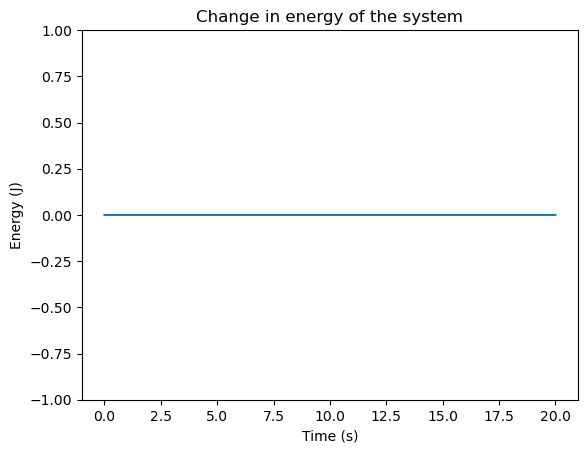

In [496]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Text(0, 0.5, 'Velocity')

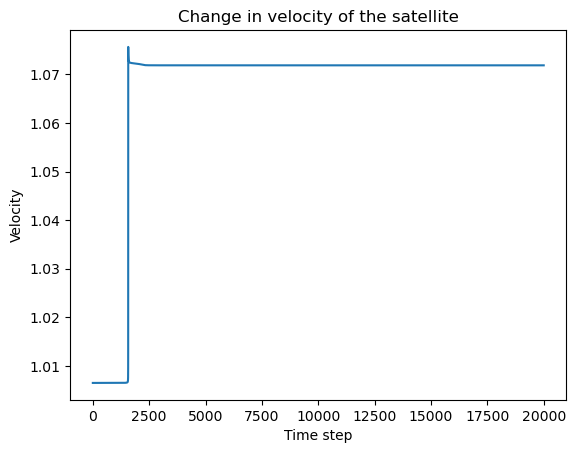

In [497]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

As can be seen from the above, there is an increase in the velocity of the satellite, and a slight decrease in the velocity of the planet. This alongside the calculations for initial and final energy also demonstrates that the conservation laws are obeyed for the most part, with a small error to the order of $10^{-10}$ that could be attributed to the limitations of the simulation. 
\
\
Now, I will attempt to do the same, but to set up the trajectory of the satellite so that it passes in front of instead of behind the planet. This, according to previous calculations, should decrease the velocity of the satellite and increase the velocity of the planet.

In [498]:
G = 1
m1 = 1
m2 = 3e-6
m3 = 1e-27
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.5, 1.5)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(-0.0005-1.5), 
                  1/1.57*(1-1.5)))



In [499]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2, r3)

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



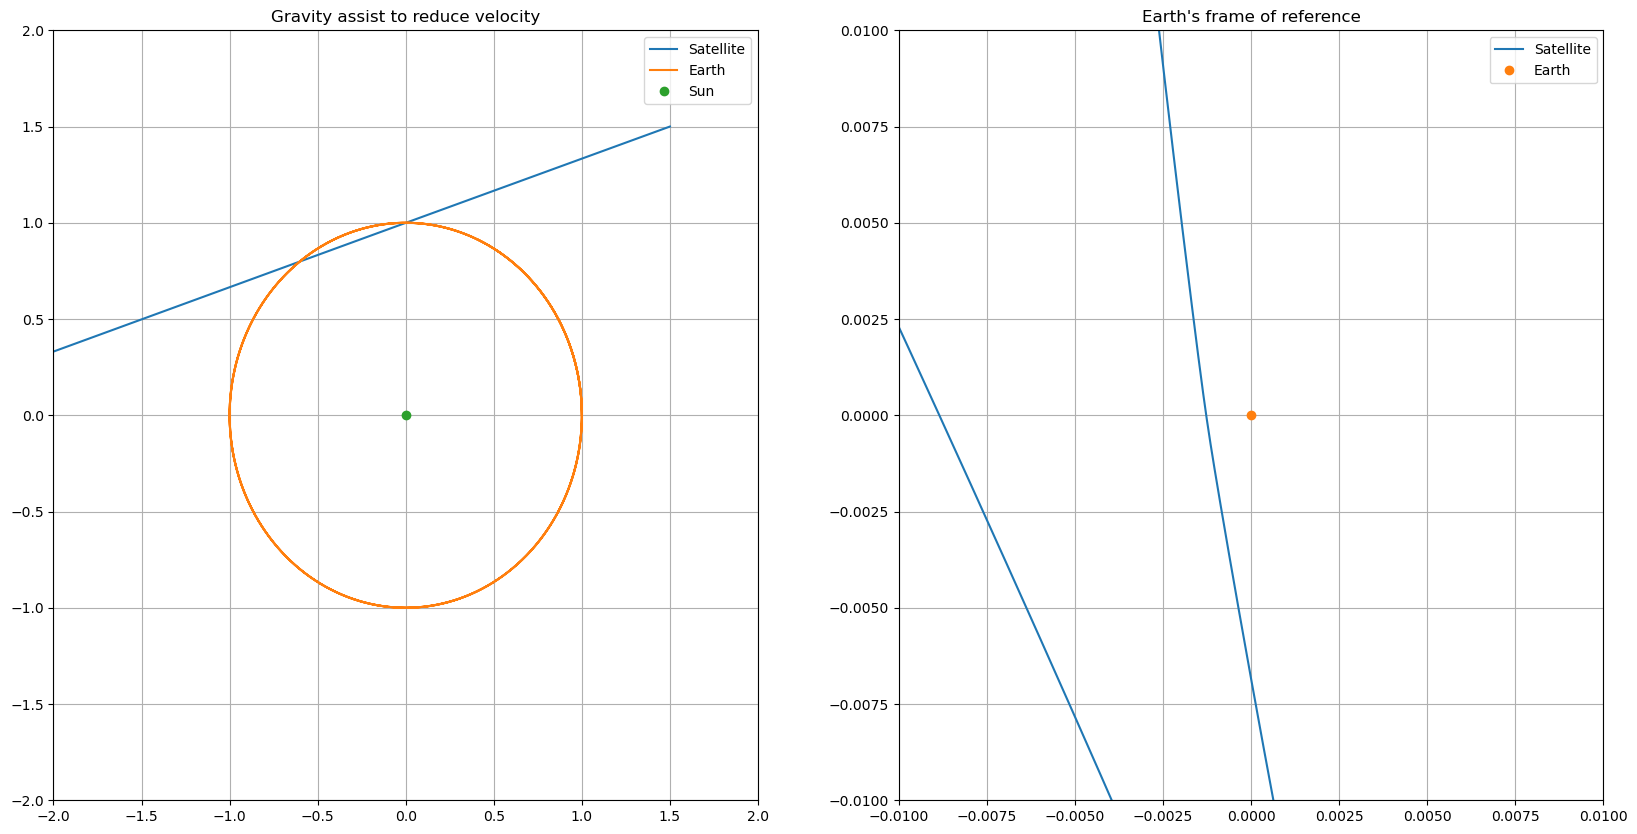

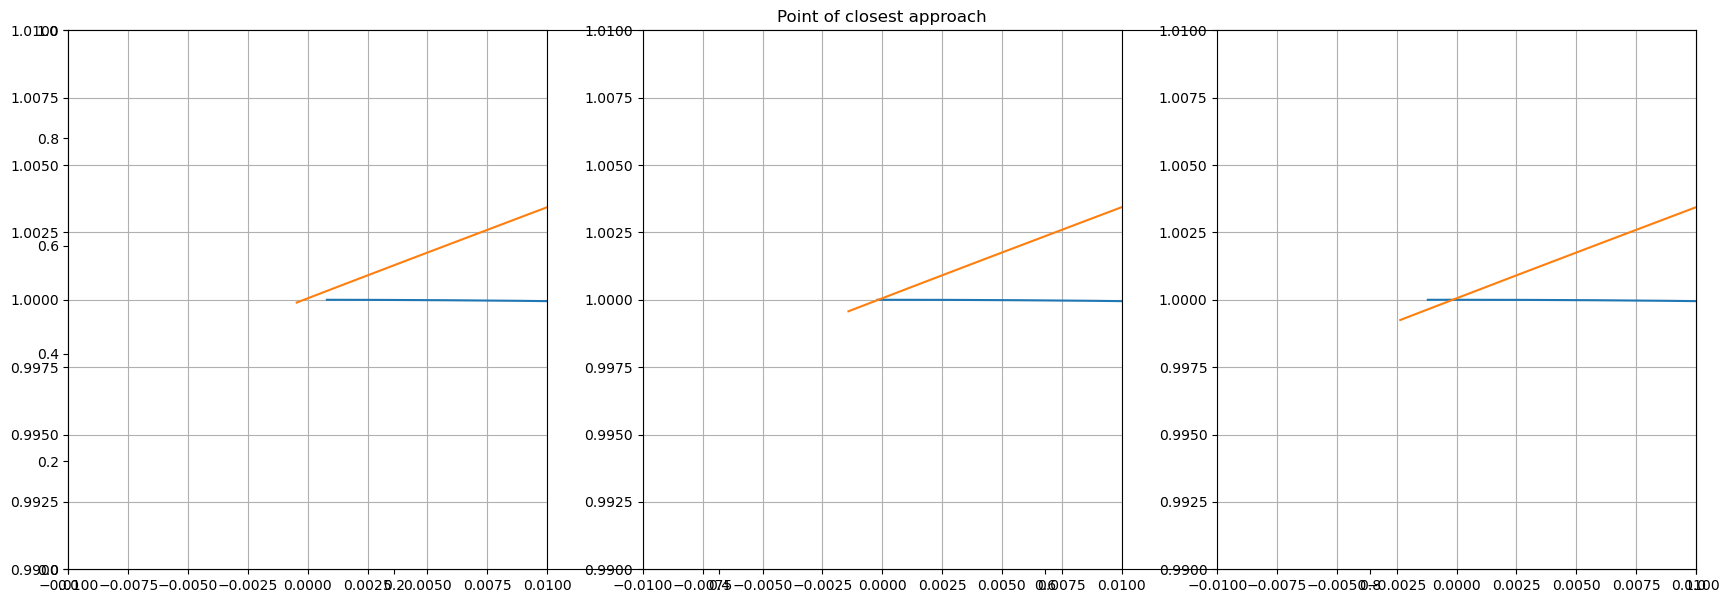

In [500]:
fig = plt.figure(figsize=(20,10 ))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Gravity assist to reduce velocity')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Earth')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Earth\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.01, 0.01)
ax2.set_ylim(-0.01, 0.01)
ax2.plot(0,0,'o',label='Earth')
ax2.grid()
ax2.legend()

simend = 1570
fig = plt.figure(figsize=(21,7))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(-0.01, 0.01)
    ax.set_ylim(0.99, 1.01)
    ax.grid()


Initial velocity of planet 3: 1.0073969297048013
Final velocity of planet 3: 0.990690232880136
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522490997
Initial energy of both planets: 1.5e-06
Final energy of both planets: 1.499999556747332e-06
Difference in energies: 4.4325266804113477e-13
Point of closest approach: 0.001264688143906504


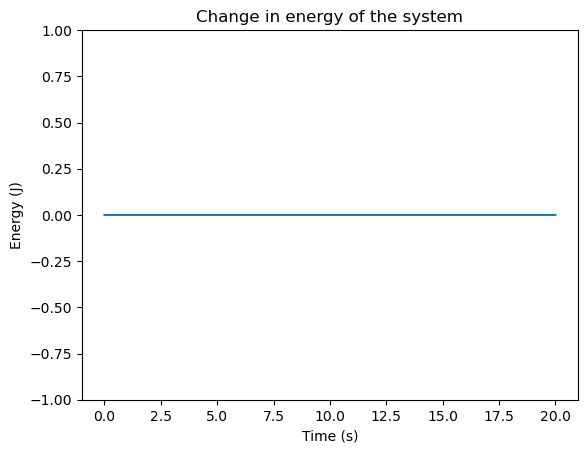

In [501]:
print(f'Initial velocity of planet 3: {np.linalg.norm(v3[0])}')
print(f'Final velocity of planet 3: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)
e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Text(0, 0.5, 'Velocity')

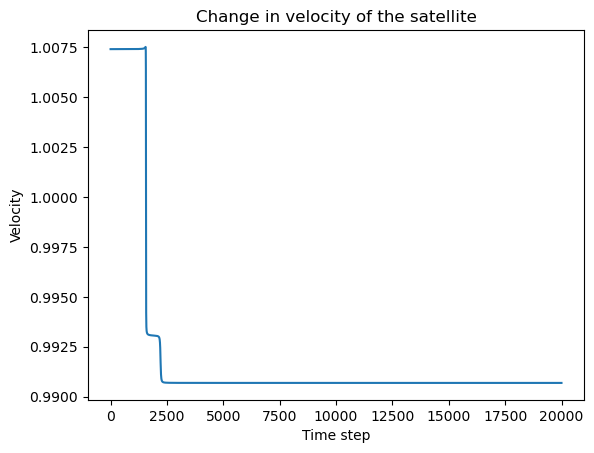

In [502]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

# Attempting a large slingshot with a larger mass
Continuing from here, we can set up a better-scaled model which can achieve some a more extreme velocity change. As opposed to considering a system comprised of Earth and the Sun, we will now explore one of Jupiter and the Sun. Upon constructing this two-body system, we will explore the motion of another satellite into the gravitational field of Jupiter. For the sake of ease, we will use the same initial conditions as previously to assist in performing calculations, as well as the same initial position of the satellite in the system. The tolerance in the `collision_checker` function will be adjusted to match the fraction of Jupiter's radius to the distance from Jupiter to the Sun ($\approx 9 \times 10^{-5}$).

In [503]:
def collision_checker(r1, r2):
    '''
    A function to check to see if two objects have collided.
    The tolerance was chosen based on earlier calculations

    Inputs:
    r1, r2   Positions of the two bodies
    '''
    if np.linalg.norm(r1 - r2) <= 9e-5:
        print('Collision!')

In [504]:
G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2     
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.5, 1.5)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(-1.5), 
                  1/1.57*(1-1.5)))

In [505]:
for i in range(Nsteps-1):
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



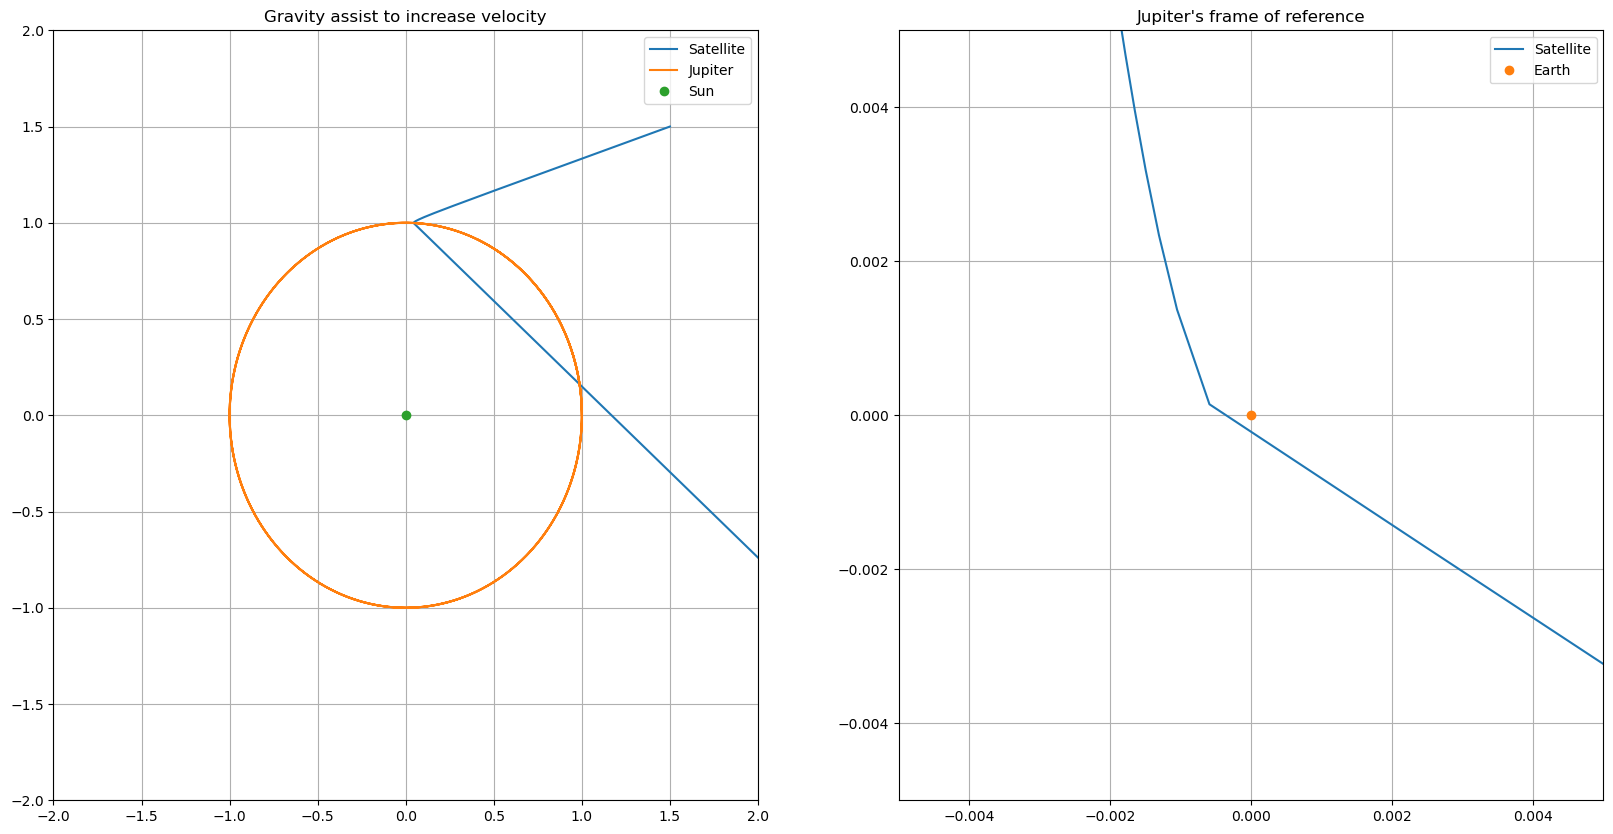

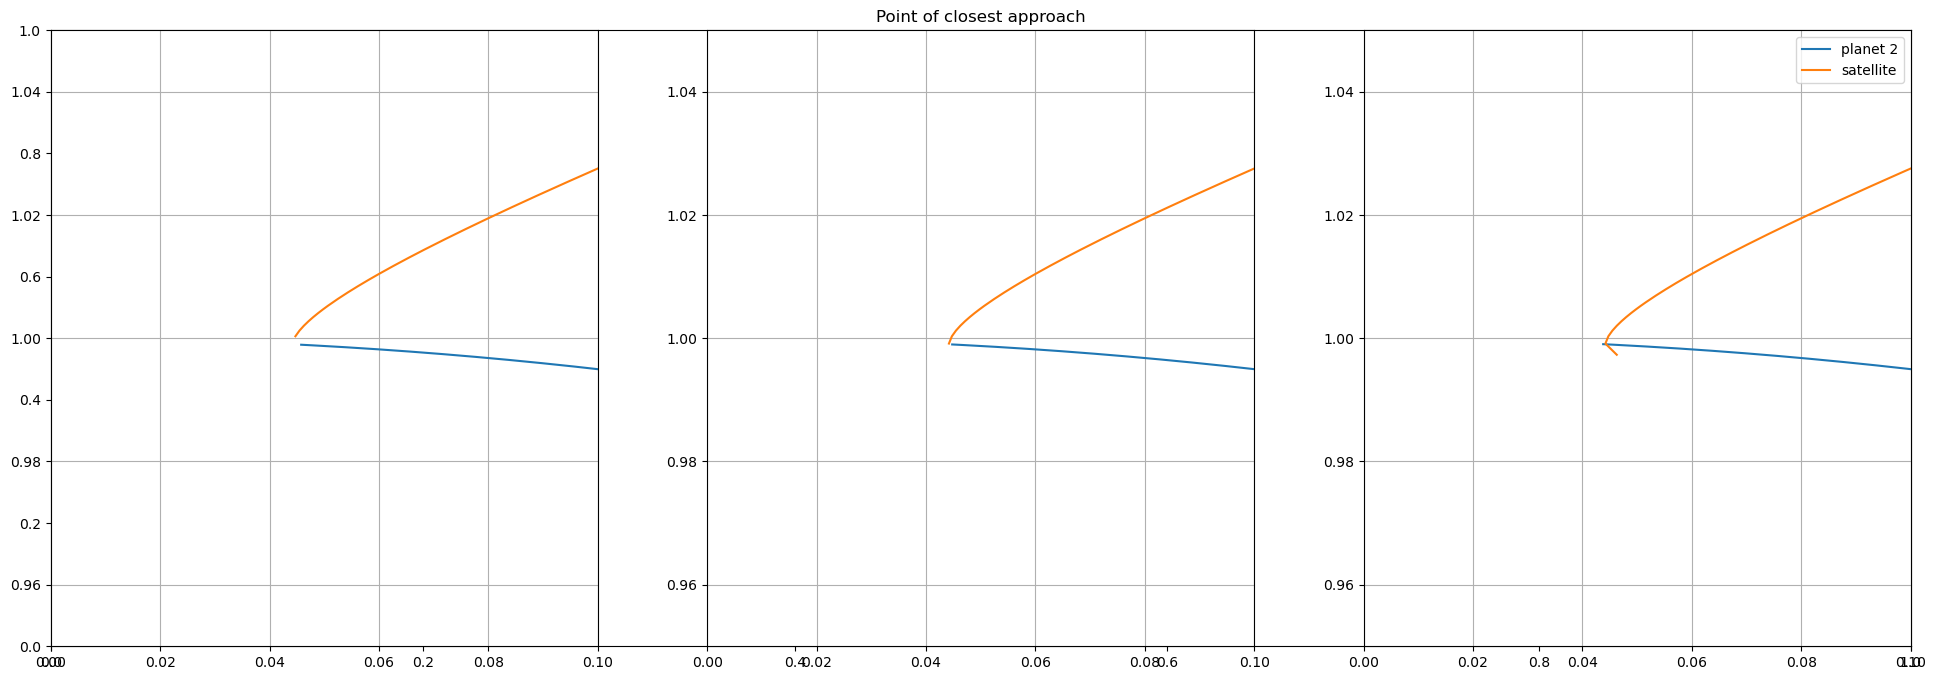

In [506]:
fig = plt.figure(figsize=(20,10 ))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Gravity assist to increase velocity')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Jupiter')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Jupiter\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.005, 0.005)
ax2.set_ylim(-0.005, 0.005)
ax2.plot(0,0,'o',label='Earth')
ax2.grid()
ax2.legend()


simend = 1525
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(0,0.1)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()


Initial velocity of satellite: 1.0070947962319678
Final velocity of satellite: 2.592455377016387
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.000609534962930454


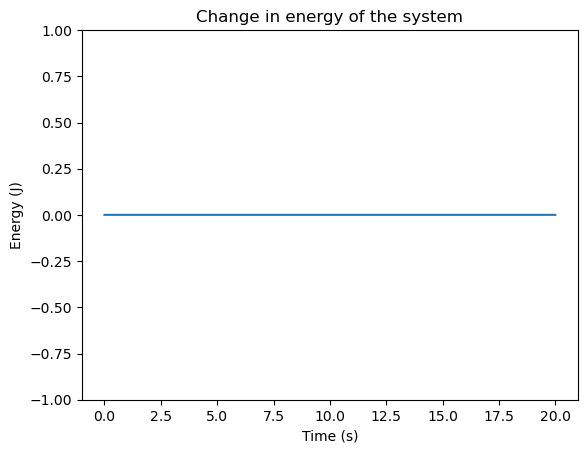

In [507]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)
e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Text(0, 0.5, 'Velocity')

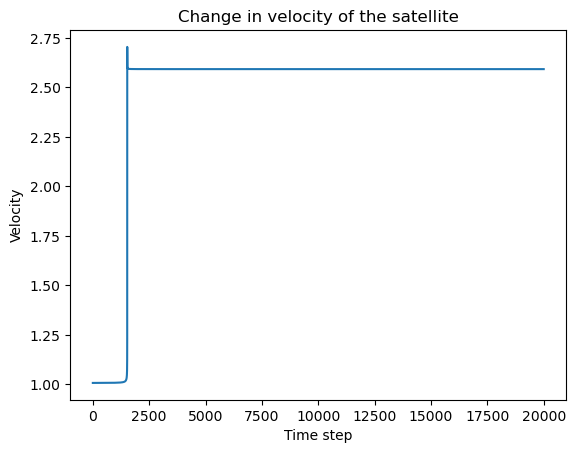

In [508]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

In [509]:
d = np.linalg.norm(r2-r3, axis=1)
closest_timestep = np.where(d == min(d))
print(closest_timestep)

print(min(d))

(array([1526], dtype=int64),)
0.000609534962930454


From the above simulation, we achieve over a two times increase in the velocity of the satellite after it passes Jupiter. This is comparable to the increase of Pioneer 10 after its gravity assist.

## Reducing Initial Velocity
While this result is satisfactory, it would be greatly beneficial to instead consider the satellite moving at a slower velocity, as this means that it can move at a greater distance from the object and still be affected by the gravitational forces. Earlier, I noticed that there is somewhat of an issue involving the timestep. Without increasing the timestep, the planet jumps, making it difficult to place the satellite either in front or behind the orbit to reduce or increase its velocity. This issue could be rectified by increasing timestep, but this comes with a large increase in processing time. Moving the starting position of the satellite closer, reducing its velocity, and increasing the point of closest approach, I should have a system that is much easier to control but also allows for good slingshots and the same processing time.

In [510]:
G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2 
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

r2[0] = np.array((1.0, 0))
r3[0] = np.array((0.25, 1.25)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(0.05-0.25), 
                  1/1.57*(1-1.25)))

In [511]:
for i in range(Nsteps-1):
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



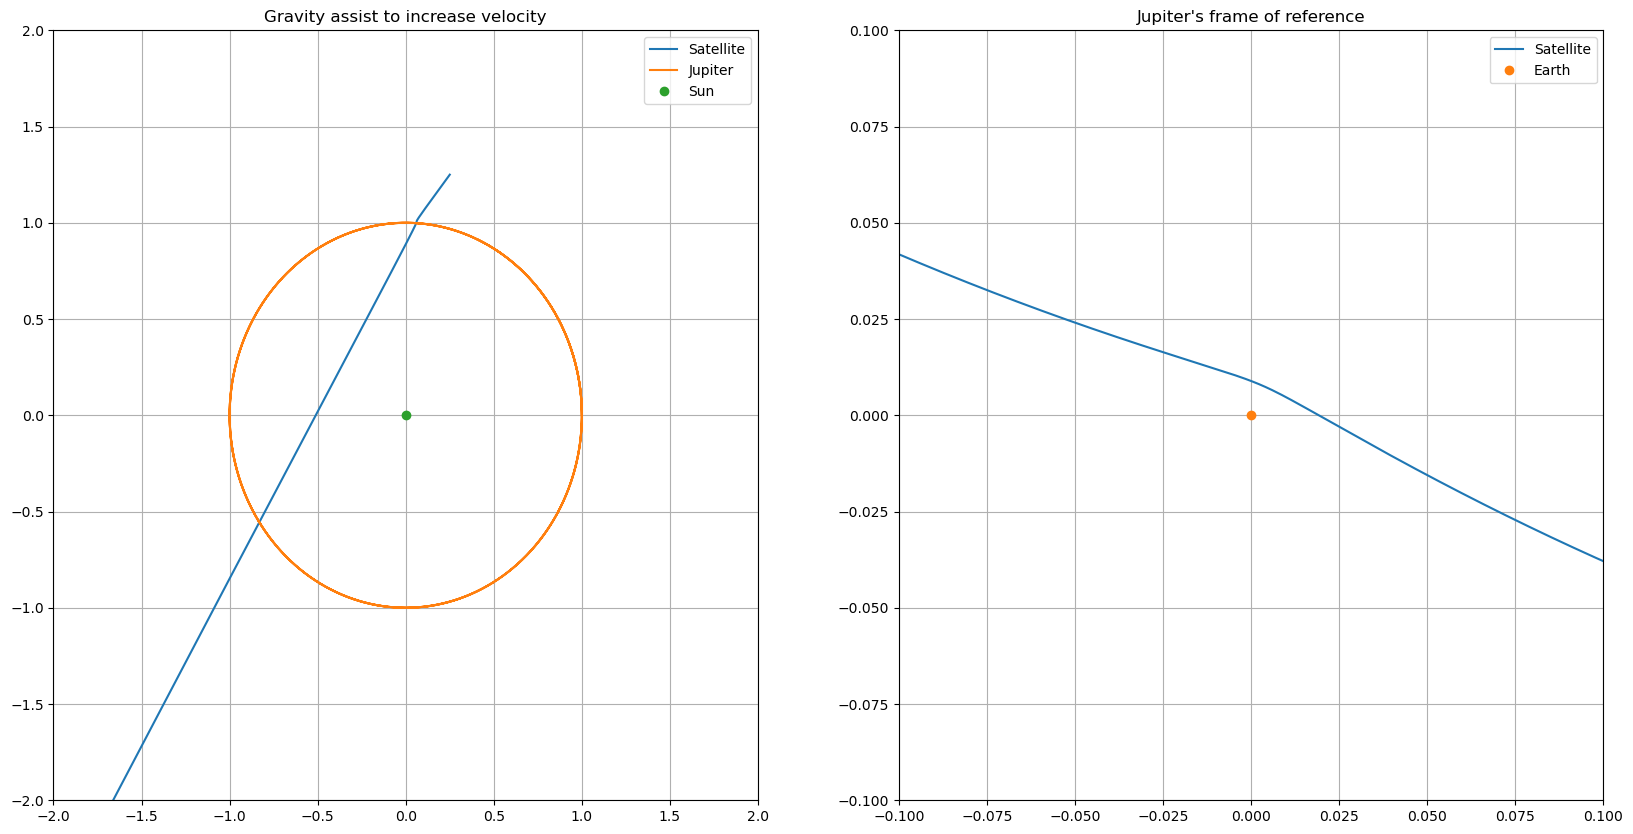

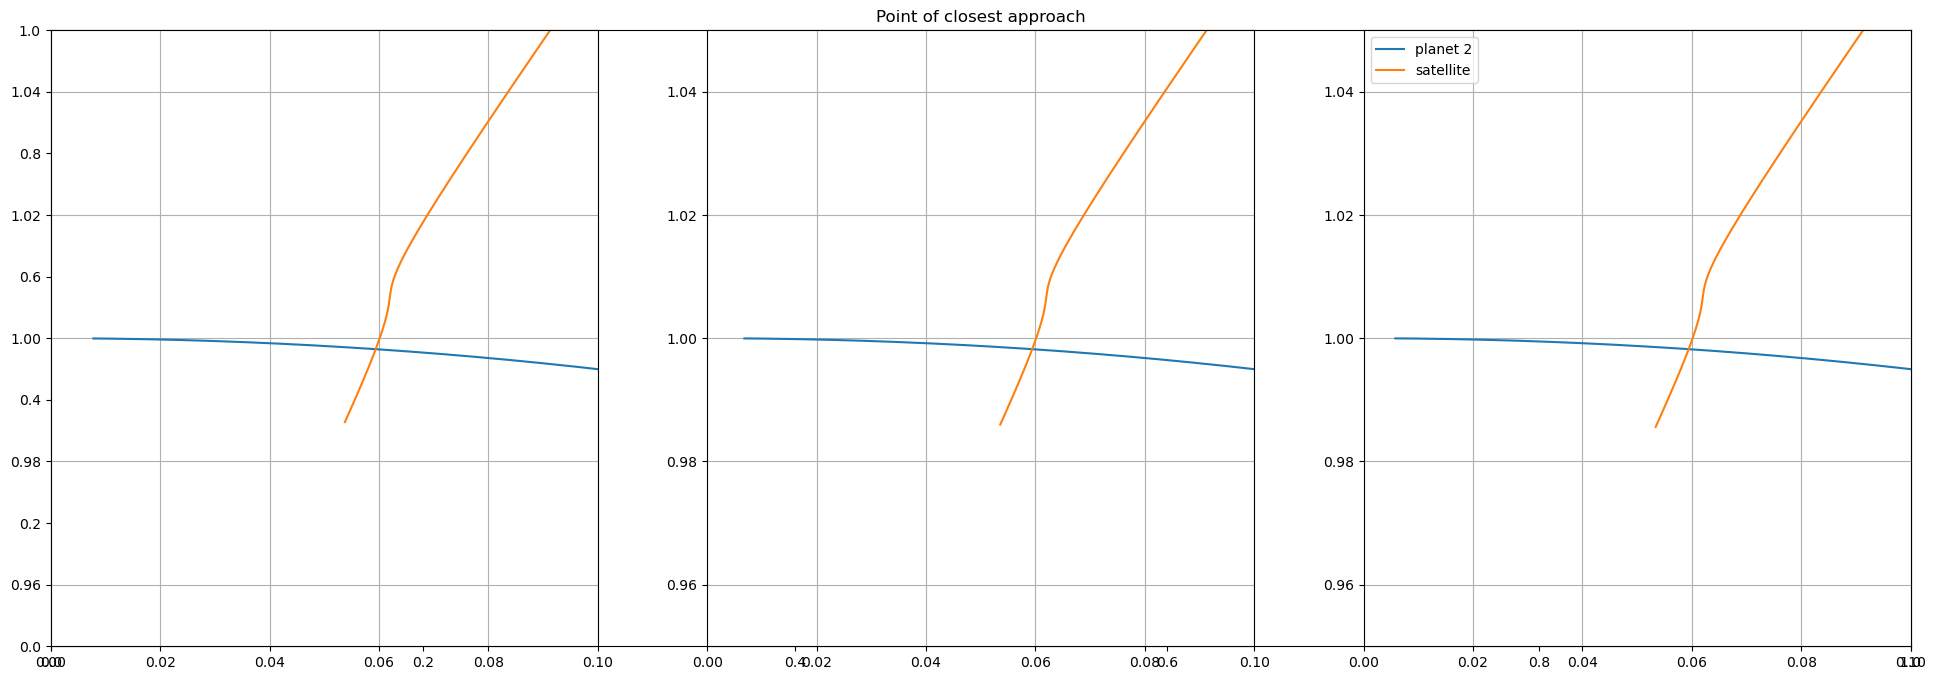

In [512]:
fig = plt.figure(figsize=(20,10 ))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Gravity assist to increase velocity')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Jupiter')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Jupiter\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax2.plot(0,0,'o',label='Earth')
ax2.grid()
ax2.legend()

simend = 1563
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(0,0.1)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()


Initial velocity of satellite: 0.20392115405837097
Final velocity of satellite: 0.4392498008497535
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.008334288441073576


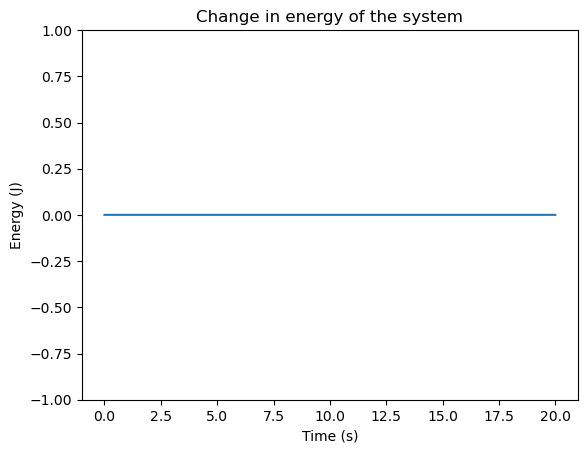

In [513]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)
e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

(array([1475], dtype=int64),)


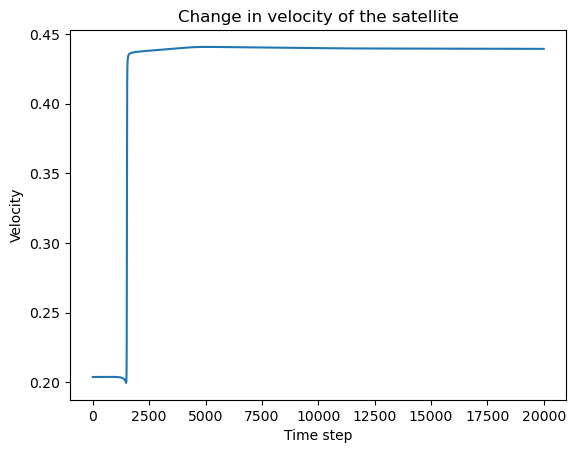

In [514]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))

In [515]:
G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2    
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

r2[0] = np.array((1.0, 0))
r3[0] = np.array((-0.25, 1.25)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(-0.1+0.25), 
                  1/1.57*(1-1.25)))

In [516]:
for i in range(Nsteps-1):
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2)) 
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



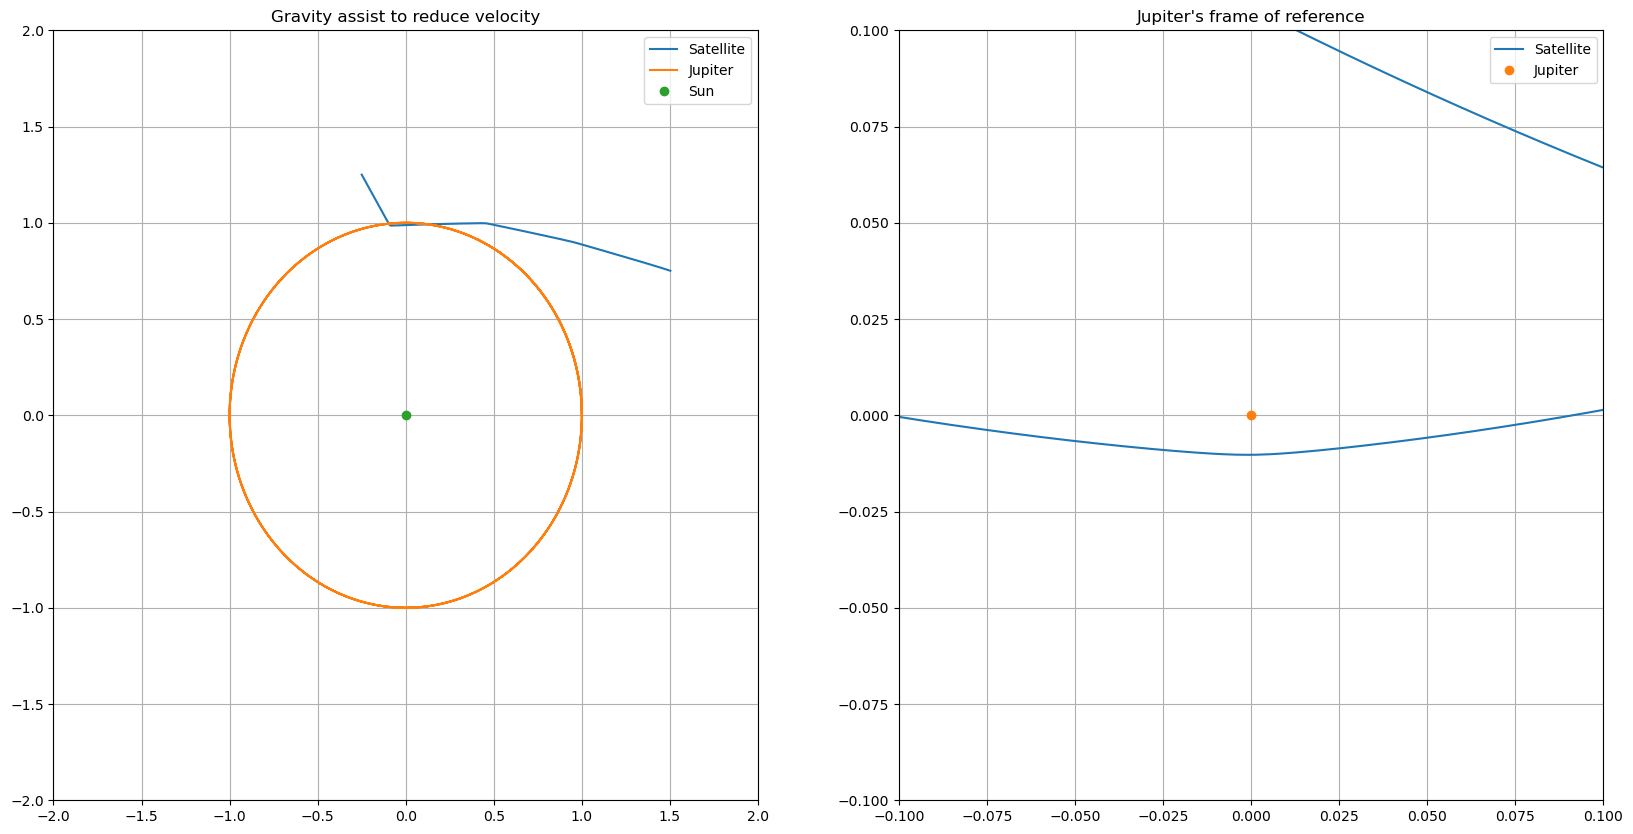

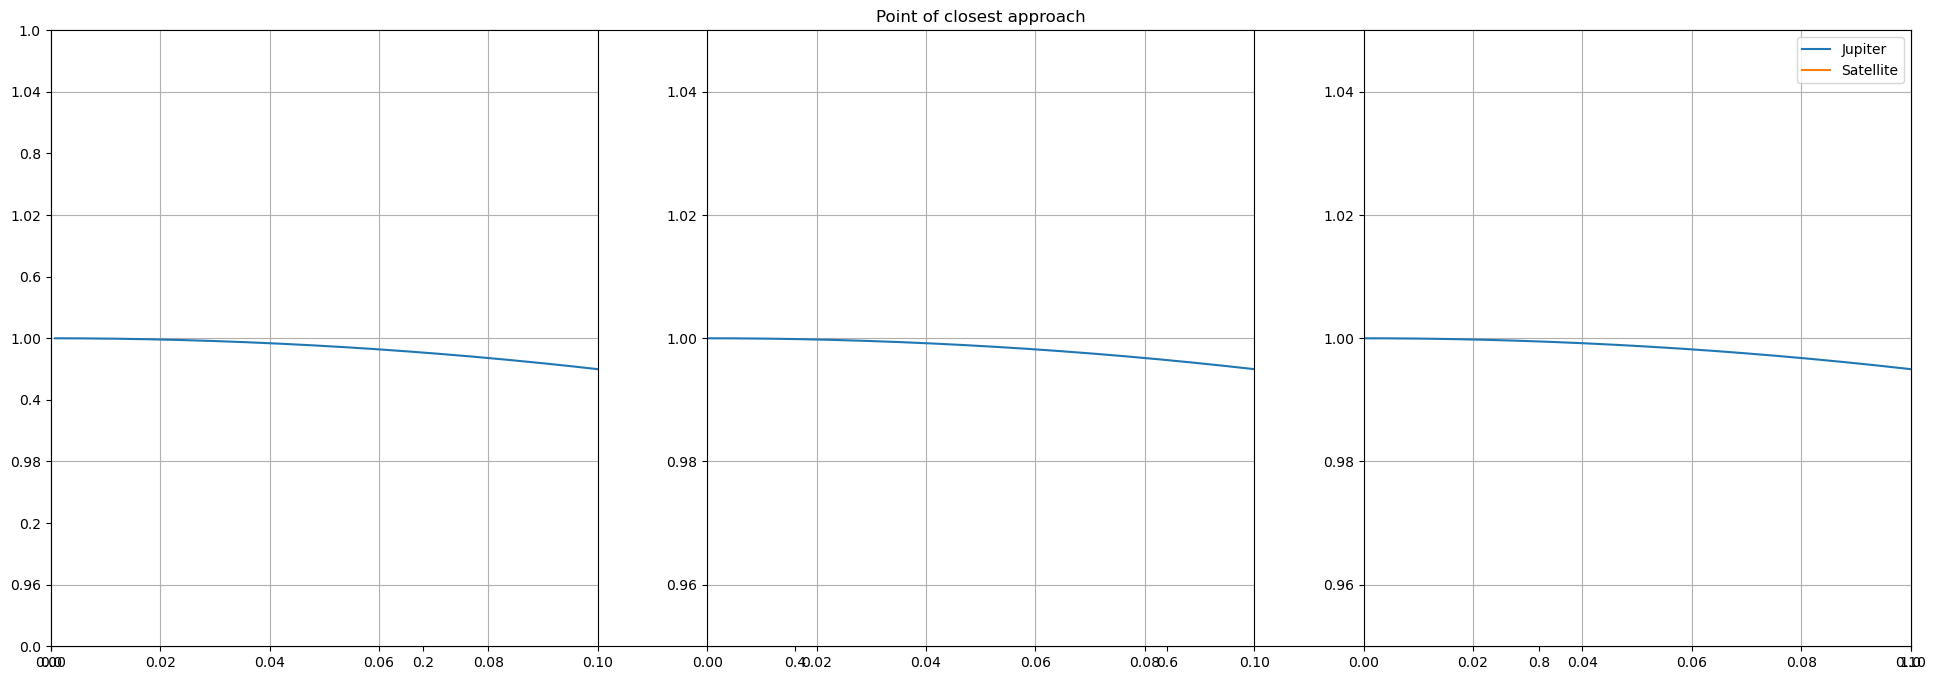

In [517]:
fig = plt.figure(figsize=(20,10 ))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Gravity assist to reduce velocity')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Jupiter')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Jupiter\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax2.plot(0,0,'o',label='Jupiter')
ax2.grid()
ax2.legend()

simend = 1570
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='Jupiter')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='Satellite')
    ax.set_xlim(0,0.1)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()

Initial velocity of satellite: 0.18569910493137898
Final velocity of satellite: 0.08193778122751921
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.01027001259176871


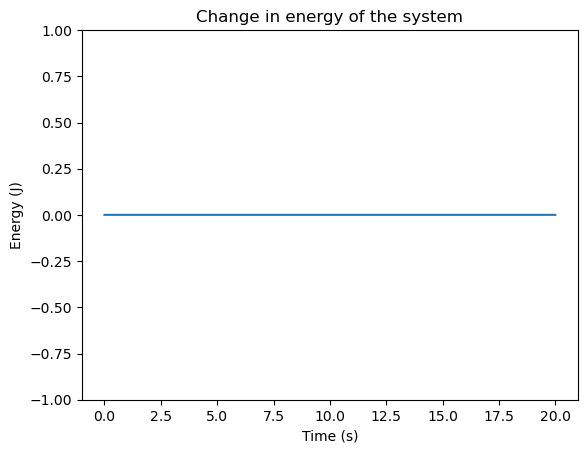

In [518]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)
e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

(array([19999], dtype=int64),)


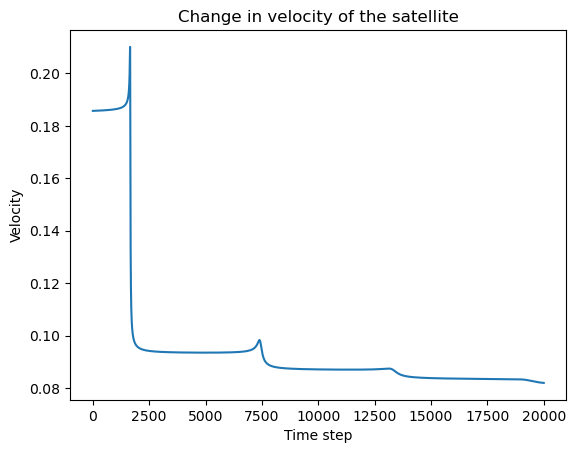

In [519]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))

As we can see during both cases, it is very much feasible to scale velocity to much greater extents by reducing the velocity of the satellite.

# Including circular orbit around the sun

Up to this point, circular orbits have not been including the influence of the sun on the satellite. As a result, these simulations are not yet good enough models for motion around the solar system. As is seen below, the method used to send the satellite to the interception point involves placing it in an elliptical orbit. To make things easier, the satellite is held stationary for a finite time, before it is deployed with the elliptical orbit. This delay was determined by the difference between the time taken for the satellite and the planet to reach the interception point.

In [520]:
G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2     
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

#lag = 1570 - 664 - this is the maximum lag before the satellite gets dangerously close to Jupiter
lag = 1570 - 654


r2[0] = np.array((1.0, 0))
r3[:lag+1] = np.array((0.5, 0)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[:lag+1] = np.array((0, np.sqrt(G*m1/0.25))) 

In [521]:
# Splitting up the velocity Verlet to facilitate the delay
for i in range(Nsteps-1):
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)

    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)

    collision_checker(r2[i], r3[i])

    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)

    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2)) 

for j in range(lag,Nsteps-1):
    f3 = force(r3[j], r2[j], m3, m2) + force(r3[j], r1[j], m3, m1)

    r3[j+1] = r3[j] + dt*v3[j] + (dt**2)*f3/(2*m3)

    collision_checker(r2[j], r3[j])

    f3new = force(r3[j+1], r2[j+1], m3, m2) + force(r3[j+1], r1[j+1], m3, m1)

    v3[j+1] = v3[j] + dt*((f3+f3new) / (2*m3))



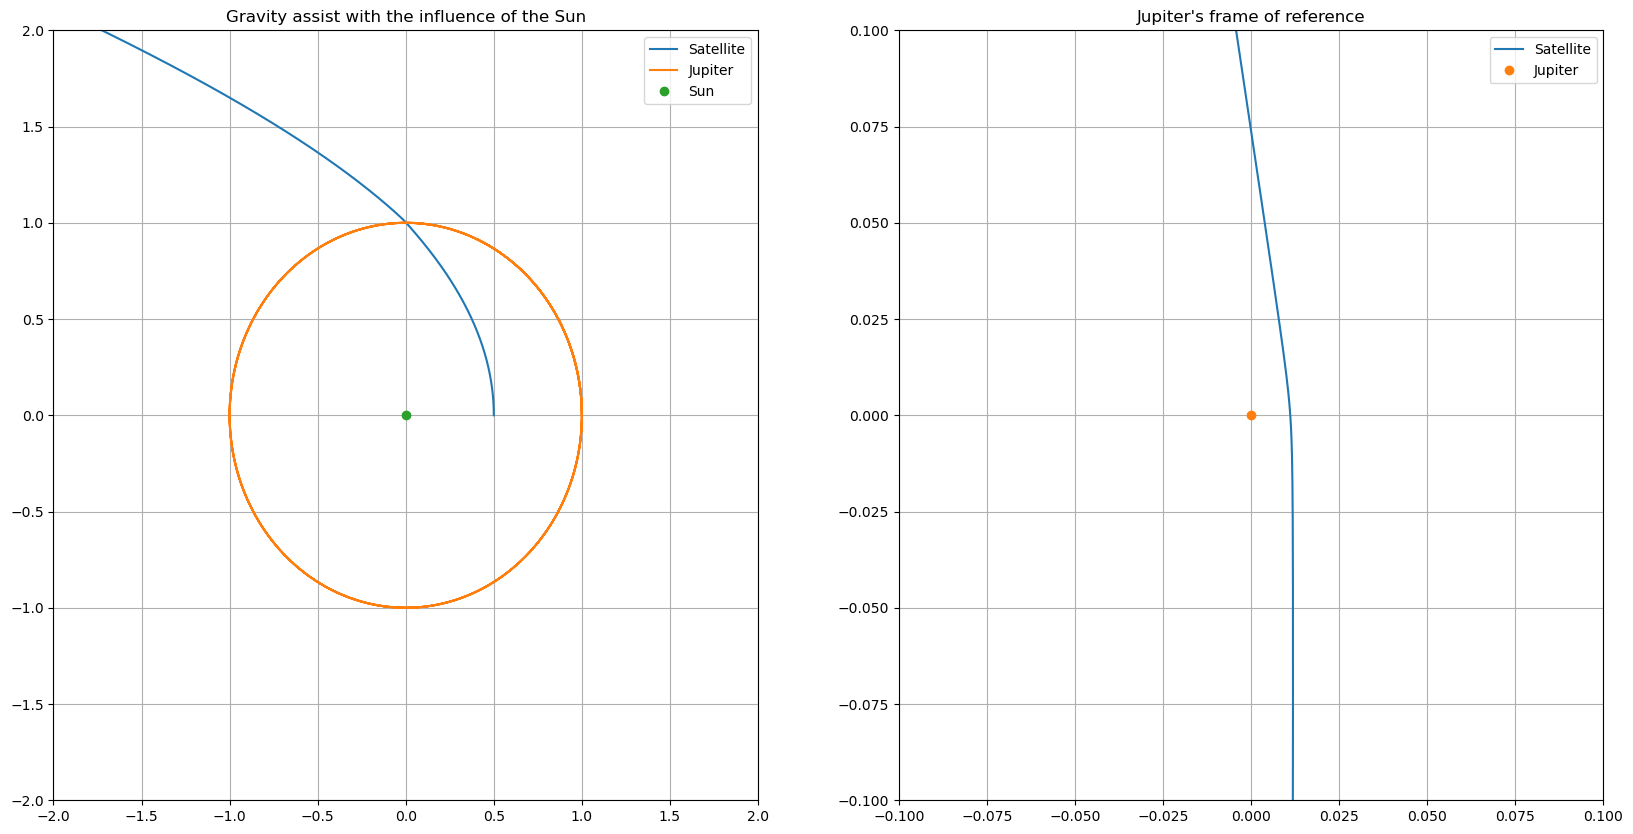

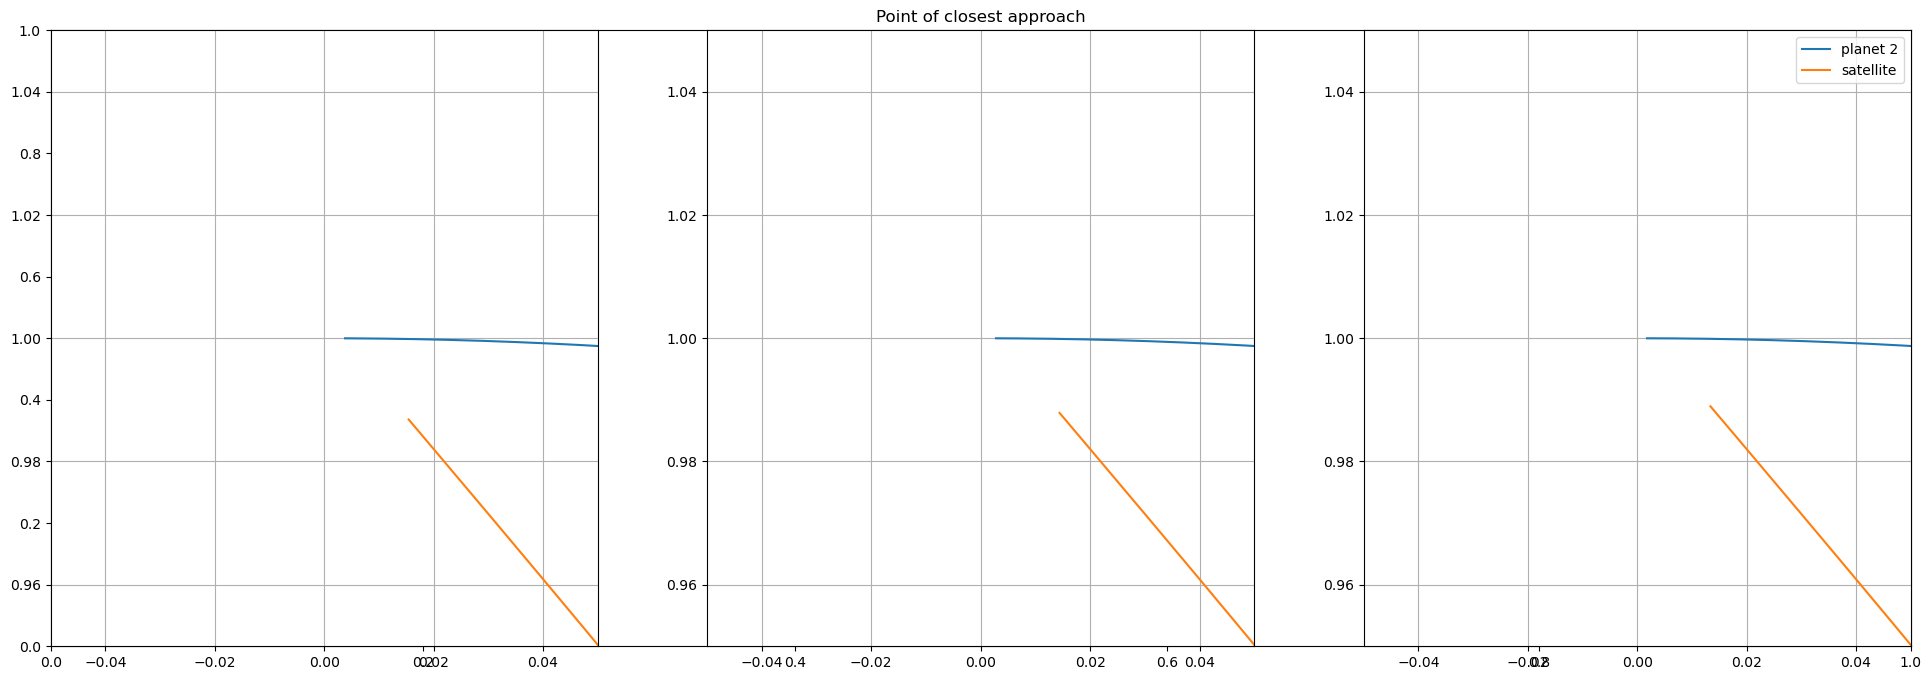

In [522]:
fig = plt.figure(figsize=(20,10 ))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Gravity assist with the influence of the Sun')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Jupiter')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Jupiter\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax2.plot(0,0,'o',label='Jupiter')
ax2.grid()
ax2.legend()

simend = 1567
n = 1
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + n*i,0], r2[:simend + n*i,1], label='planet 2')
    ax.plot(r3[:simend + n*i,0], r3[:simend + n*i,1], label='satellite')
    ax.set_xlim(-0.05,0.05)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()


Initial velocity of satellite: 2.0
Final velocity of satellite: 0.6864416238540269
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of system: 0.0005
Final energy of system: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.011061329643319073


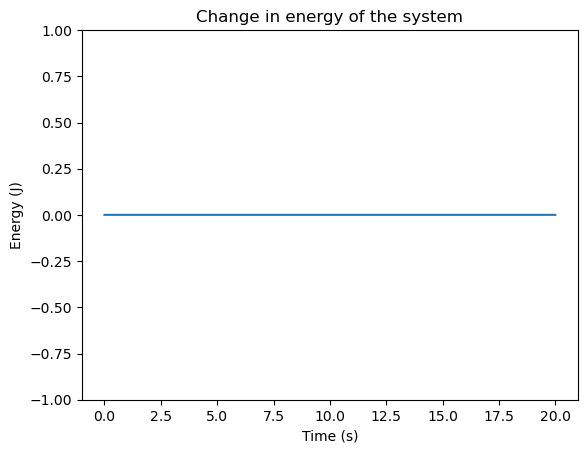

In [523]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)
e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of system: {e_0}')
print(f'Final energy of system: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

(array([19999], dtype=int64),)


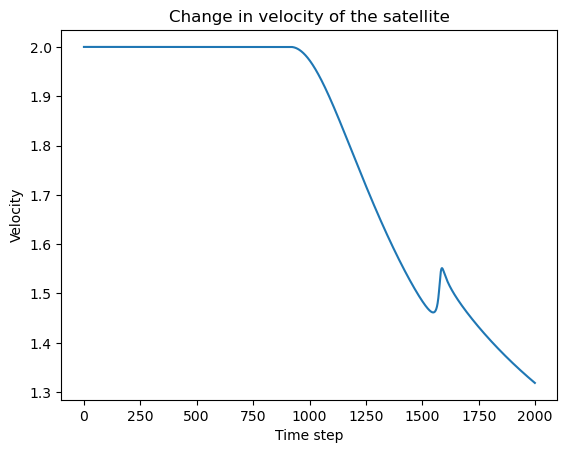

In [524]:
plt.plot(np.linalg.norm(v3[:2000],axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))

We can see here that we get a very satisfactory gravity assist from Jupiter by lagging the satellite s.t. it intersects it at the right point in time.

# Introducing a fourth body
Given my success with the previous part, I will attempt to model a fourth body which the satellite can subsequently slingshot off. The planet in question will be Saturn, with the orbital radius and mass approximately reflecting this. A similar approach to earlier parts was taken, with the orbit of Saturn also delayed so that it reaches the intersection point with the satellite.

In [525]:
G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
m4 = 1e-4
Ndim = 2     
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
r4 = np.zeros((Nsteps, Ndim))

v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))
v4 = np.zeros((Nsteps, Ndim))

#lag = 1570 - 664 - this is the maximum lag before the satellite gets dangerously close to Jupiter
lag = 1570 - 659

#lag2 = 2511 - 6898 - see above
lag2 = 2511 - 6892

# Initial conditions
r2[0] = np.array((1.0, 0))
r4[:lag2+1] = np.array((0, 2.0))
r3[:lag+1] = np.array((0.5, 0)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v4[:lag2+1] = np.array((2.35*np.sqrt(G*m1/2), 0))
v3[:lag+1] = np.array((0, np.sqrt(G*m1/0.25)))

In [526]:
for i in range(Nsteps-1):
    f2 = force(r2[i], r1[i], m2, m1) 

    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)

    f2new = force(r2[i+1], r1[i+1], m2, m1) 

    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2)) 


for j in range(lag2, Nsteps-1):
    f4 = force(r4[j], r1[j], m4, m1) 

    r4[j+1] = r4[j] + dt*v4[j] + (dt**2)*f4/(2*m4)

    f4new = force(r4[j+1], r1[j+1], m2, m1) 

    v4[j+1] = v4[j] + dt*((f4+f4new) / (2*m4)) 


for k in range(lag,Nsteps-1):
    f3 = force(r3[k], r2[k], m3, m2) + force(r3[k], r4[k], m3, m2) + force(r3[k], r1[k], m3, m1)

    r3[k+1] = r3[k] + dt*v3[k] + (dt**2)*f3/(2*m3)

    f3new = force(r3[k+1], r2[k+1], m3, m2) + force(r3[k+1], r4[k+1], m3, m2) + force(r3[k+1], r1[k+1], m3, m1)

    v3[k+1] = v3[k] + dt*((f3+f3new) / (2*m3))


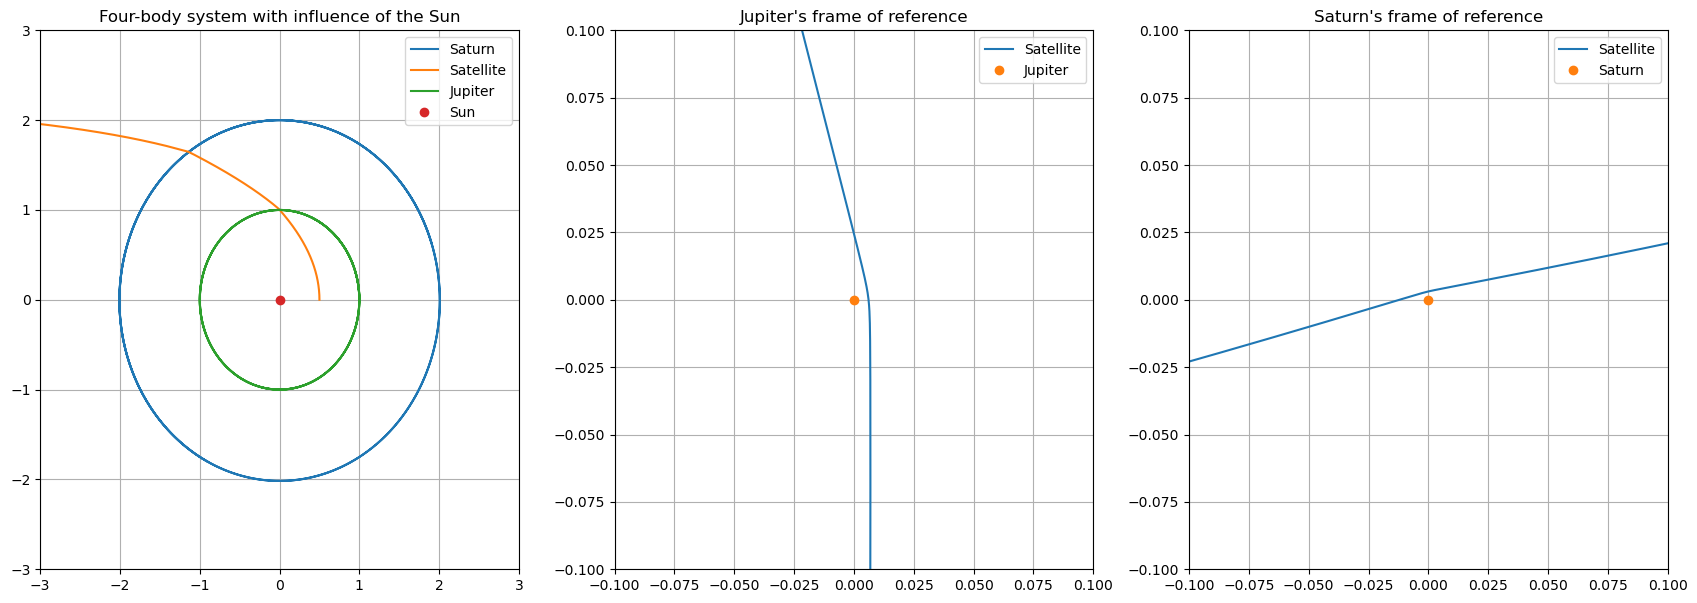

In [530]:
fig = plt.figure(figsize=(21,7))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Four-body system with influence of the Sun')
ax1.plot(r4[:,0], r4[:,1], label='Saturn')
ax1.plot(r3[:,0], r3[:,1], label='Satellite')
ax1.plot(r2[:,0], r2[:,1], label='Jupiter')
ax1.plot(0, 0, 'o', label='Sun')
ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)
ax1.grid()
ax1.legend() 

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Jupiter\'s frame of reference')
ax2.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1], label='Satellite')
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax2.plot(0,0,'o',label='Jupiter')
ax2.grid()
ax2.legend()

ax2 = fig.add_subplot(1,3,3)
ax2.set_title('Saturn\'s frame of reference')
ax2.plot(r3[:,0]-r4[:,0], r3[:,1]-r4[:,1], label='Satellite')
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax2.plot(0,0,'o',label='Saturn')
ax2.grid()
ax2.legend()

(array([19999], dtype=int64),)


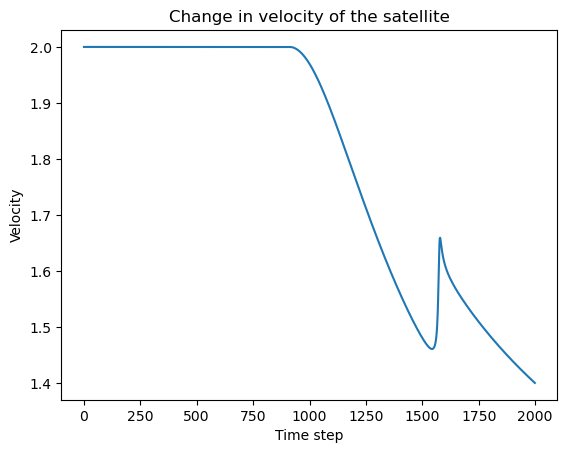

In [528]:
'''# Rough working
mag_r3 = np.linalg.norm(r3, axis=1)
print(np.where(abs(mag_r3 - 2) < 1e-3))

mag_r4 = np.linalg.norm(r4, axis=1)
print(np.where(abs(r4 - r3[2511]) < 1e-3))
'''

plt.plot(np.linalg.norm(v3[:2000],axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))


Initial velocity of satellite: 2.0
Final velocity of satellite: 0.6383267996673603
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0006359817623039956
Final energy of both planets: 0.0006372080018867433
Difference in energies: -1.2262395827476345e-06
Point of closest approach: 0.006060123497546417


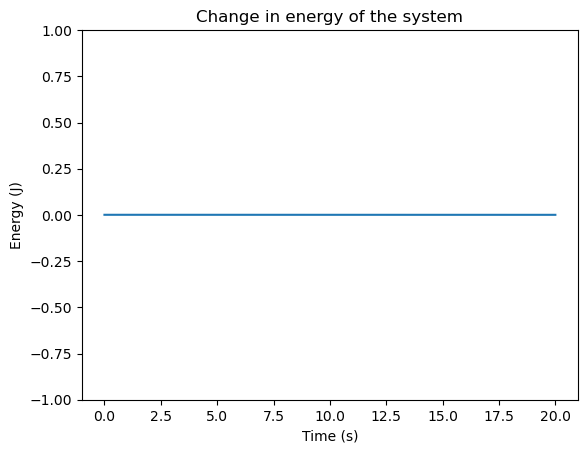

In [531]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2 + m4*np.linalg.norm(v4[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2 + m4*np.linalg.norm(v4[-1])**2)
e = 0.5 * (m2*np.linalg.norm(v2,axis=1)**2 + m3*np.linalg.norm(v3,axis=1)**2 + m4*np.linalg.norm(v3,axis=1)**2)
plt.plot(np.arange(len(e))*dt,e)
plt.title('Change in energy of the system')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.ylim(-1,1)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')